# Investigating Moreton Bay Normalised Differenital Chlorophyll Index (NDCI) phenology
The purpose of this notebook is to download **DEA ARD** from sentinel 2 and/or landsat and calculate NDCI and distangle known high ch eventspotentially leading to poor water quality, algale blooms and impacting local fishing.
This notebook will
1. Collect to the DEA STAC and load libraries.
2. Indentify the region of interest, Moreton bay, and our temporal context
3. Load the relevant satelite data to caclualte NDCI.
4. Extract and aggregate NCDI values over morten bay.
5. Plot the NDCI over time and compare against known inflow data and rainfall.
6. Look for high intesnity NDCI data and try and indentify poor water qu and algal blooms.

For Sentinel-2, NDCI is an index that aims to predict the chlorophyll content in turbid productive waters. It is calculated using the red spectral band Red with the red edge spectral band Red edge 1. This study measures the presence of water through the modified normalised difference water index (MNDWI) and clorophyll-*a* through the normalised difference clorophyll index (NDCI).

MNDWI is calculated from the green and shortwave infrared (SWIR) bands to identify water.
The formula is

$$
\begin{aligned}
\text{MNDWI} = \frac{\text{Green} - \text{SWIR}}{\text{Green} + \text{SWIR}}.
\end{aligned}
$$

When interpreting this index, values greater than 0 indicate water.

NDCI is calculated from the red edge 1 and red bands to identify water.
The formula is

$$
\begin{aligned}
\text{NDCI} = \frac{\text{Red edge 1} - \text{Red}}{\text{Red edge 1} + \text{Red}}.
\end{aligned}
$$

When interpreting this index, high values indicate the presence of clorophyll-*a*.

### Collect to the DEA STAC and load libraries.

In [4]:
# Import required libraries
import pystac_client
import odc.stac 
# Connect to DEA STAC catalog
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")
# Configure the Amazon web service
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

### Indentify the region of interest, Moreton bay, and our temporal context

In [6]:
import folium

# Define the function to display a map
def display_map(lon_range, lat_range):
    # Calculate the center of the bounding box
    center = [(lat_range[0] + lat_range[1]) / 2, (lon_range[0] + lon_range[1]) / 2]

    # Create a folium map
    m = folium.Map(location=center, zoom_start=10)

    # Draw a rectangle to show the bounding box
    folium.Rectangle(
        bounds=[(lat_range[0], lon_range[0]), (lat_range[1], lon_range[1])],
        color="blue",
        fill=True,
        fill_opacity=0.2
    ).add_to(m)

    return m  # Displays the map in Jupyter Notebook

# Bounding box: [xmin, ymin, xmax, ymax] -> [min_lon, min_lat, max_lon, max_lat]
bbox = [153.057702, -27.835773, 153.598474, -27.035502]

# Extract longitude and latitude ranges
lon_range = [bbox[0], bbox[2]]  # min_lon, max_lon
lat_range = [bbox[1], bbox[3]]  # min_lat, max_lat




In [7]:
# The code below renders a map that can be used to view the region.

display_map(lon_range, lat_range)

### Load the relevant satelite data to calculate NDCI.

In [20]:
# Choose products to load
# Here, the Sentinel-2a and Sentinel-2b products are chosen
collections = [
    "ga_s2am_ard_3",
    "ga_s2bm_ard_3",
]
# Build a query with the parameters above
query = catalog.search(
    bbox=bbox,
    collections=collections,
    datetime=f"2023-01-01/2023-01-12",
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 14 datasets


In [22]:
ds = odc.stac.load(
    items,
    bands=["nbart_red", "nbart_green", "nbart_blue"],  
    crs="utm",
    resolution=80,
    groupby="solar_day",
    bbox=bbox,
)


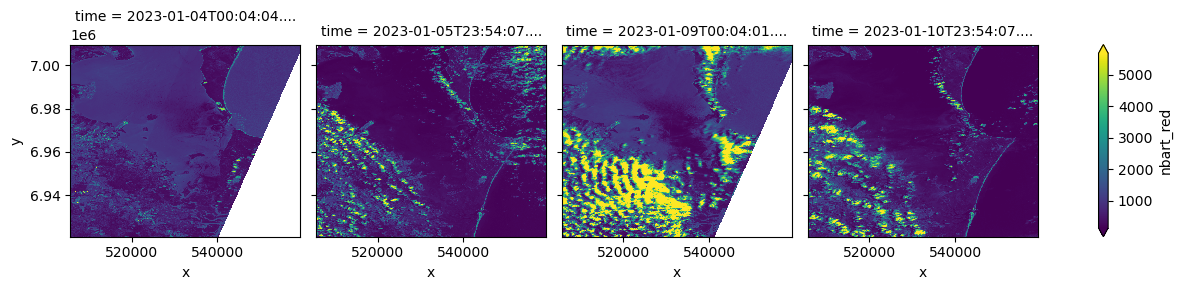

In [24]:
ds.nbart_red.plot(col="time", robust=True);

In [26]:
items[0]

<Item id=204bbbac-a477-432e-8865-7bf4c2176ff9>

In [34]:
# Set up a filter query
filter_query = "eo:cloud_cover < 20"

# Define the start and end date variables
start_date = "2021-11-01"
end_date = "2021-12-31"

# Query with sorting
query = catalog.search(
    bbox=bbox,
    collections=collections,
    datetime=f"{start_date}/{end_date}",  # ✅ Now these variables are defined
    sortby="eo:cloud_cover",
)

# Print out cloud cover values from low to high
[i.properties["eo:cloud_cover"] for i in query.items()]


[1.0649206508568023,
 1.0809653333232472,
 1.1283381923675908,
 1.2103252947678074,
 1.3547700710707755,
 1.9843291707784816,
 2.0027009203055983,
 2.7383588739728086,
 3.091359464507627,
 4.6858752738041645,
 11.835145557974394,
 18.53318566009798,
 23.775269965773045,
 24.17277383117128,
 24.397593452326166,
 28.106435411043407,
 28.953717893704408,
 28.9814215660922,
 29.38709213888747,
 31.262869221212007,
 31.303365090739117,
 32.24092514825419,
 36.427300697526086,
 36.46259634175069,
 39.50393371454487,
 39.687595119886495,
 40.49495799498694,
 41.21138186699939,
 41.278322983555,
 42.302971277664724,
 43.26699260460999,
 43.36628187730667,
 44.7546419293244,
 52.964837935486344,
 54.24568422379033,
 54.82984312692536,
 56.54217927083502,
 59.23993837667562,
 60.125147236206324,
 62.16409216718496,
 63.25476754490565,
 66.94728674191288,
 67.74638951063608,
 72.9822873422722,
 74.99821824809231,
 79.12629248903784,
 80.26952399857744,
 81.64506753461336,
 86.96014275424119,
 88.

In [36]:
# Query with sorting and fixed datetime format
query = catalog.search(
    bbox=bbox,
    collections=collections,
    datetime="2021-11-01/2021-12-31",  
    sortby="eo:cloud_cover",
)

# Print out cloud cover values from low to high
[i.properties["eo:cloud_cover"] for i in query.items()]


[1.0649206508568023,
 1.0809653333232472,
 1.1283381923675908,
 1.2103252947678074,
 1.3547700710707755,
 1.9843291707784816,
 2.0027009203055983,
 2.7383588739728086,
 3.091359464507627,
 4.6858752738041645,
 11.835145557974394,
 18.53318566009798,
 23.775269965773045,
 24.17277383117128,
 24.397593452326166,
 28.106435411043407,
 28.953717893704408,
 28.9814215660922,
 29.38709213888747,
 31.262869221212007,
 31.303365090739117,
 32.24092514825419,
 36.427300697526086,
 36.46259634175069,
 39.50393371454487,
 39.687595119886495,
 40.49495799498694,
 41.21138186699939,
 41.278322983555,
 42.302971277664724,
 43.26699260460999,
 43.36628187730667,
 44.7546419293244,
 52.964837935486344,
 54.24568422379033,
 54.82984312692536,
 56.54217927083502,
 59.23993837667562,
 60.125147236206324,
 62.16409216718496,
 63.25476754490565,
 66.94728674191288,
 67.74638951063608,
 72.9822873422722,
 74.99821824809231,
 79.12629248903784,
 80.26952399857744,
 81.64506753461336,
 86.96014275424119,
 88.

Extract and aggregate NCDI values over morten bay.

In [39]:
import datacube
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.insert(1, "../Tools/")
from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 5.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50692,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 5.21 GiB
Comm: tcp://127.0.0.1:50697,Total threads: 8
Dashboard: http://127.0.0.1:50698/status,Memory: 5.21 GiB
Nanny: tcp://127.0.0.1:50695,


In [51]:
import os
os.environ["DATACUBE_CONFIG_PATH"] = os.path.expanduser("~/.config/datacube/datacube.conf")
import datacube
dc = datacube.Datacube(app="Chlorophyll_monitoring")
print(dc.list_products())

ValueError: No ODC environment, checked configurations for ['default', 'datacube']

In [ ]:
# Define the area of interest
latitude = (-27.835773, -27.035502) 
longitude = (153.057702, 153.598474)

# Set the range of dates for the analysis
time = ("2018-07-01", "2019-03-01")

In [ ]:
display_map(x=longitude, y=latitude)